In [1]:
from __future__ import print_function

import sys
import os
from glob import glob
from time import time
%matplotlib inline
#%load_ext autoreload
#%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np
import math
#plt.rcParams['figure.figsize'] = 10,8
import datetime

from   invisible_cities.database import load_db
from   invisible_cities.core.system_of_units_c import SystemOfUnits
import invisible_cities.sierpe.blr as blr
import invisible_cities.core.mpl_functions as mpl
import invisible_cities.reco.wfm_functions as wfm
import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.core.peak_functions_c as cpf
import invisible_cities.reco.pmaps_functions as pf
import invisible_cities.core.sensor_functions as sf
from   invisible_cities.core.core_functions import define_window

import invisible_cities.core.pmaps_functions_c as cpm
from   invisible_cities.core.core_functions import lrange
 
units = SystemOfUnits()
t0 = time()

In [2]:
#import S1S2prop as prop
#import plotting as plot

In [3]:
#%%
mydf_file = os.environ['IC_DATA']+'/pmaps_JM_NEW/Kr/dst_NEXT_v0_08_09_Kr_ACTIVE_0_0_7bar_pmaps_10000.root.h5'
#mydf_file = os.environ['IC_DATA']+'/pmaps_JM/Kr/pmaps_NEXT_v0_08_09_Kr_ACTIVE_1_0_7bar__10000.root.h5'
#mydf_file = os.environ['IC_DATA']+'/pmaps_JM_NEW/Kr/dst_NEXT_v0_08_09_Kr_ACTIVE_10_0_7bar_pmaps_10000.root.h5'
print(mydf_file)

S1df, S2df, S2Sidf = pf.read_pmaps(mydf_file)

#mydf
#mydf = pf.read_pmaps(mydf_file)
#list(map(type, mydf))
#S1df   = mydf[0]
#S2df   = mydf[1]
#S2Sidf = mydf[2]

print('S1df entries (tbins x events):',len(S1df))
print('S2df entries (tbins x events):',len(S2df))
print('S2Sidf entries:',len(S2Sidf))
type(S1df)
print('Keys of S1df panda dataframe: {} '  .format(S1df.keys()))
print('Keys of S2df panda dataframe: {} '  .format(S2df.keys()))
print('Keys of S2Sidf panda dataframe: {} '.format(S2Sidf.keys()))

# Convert S12df object  (an S12 pytable read as a PD dataframe) and return an S12L dictionary (list of dict, first dict)
S1dict   = pf.df_to_pmaps_dict(S1df,10000)  # revisar NO poner event max
S2dict   = pf.df_to_pmaps_dict(S2df,10000)
S2Sidict = pf.df_to_s2si_dict (S2Sidf,10000)

evid_S1min   = sorted(S1dict.keys())  [0]
evid_S1max   = sorted(S1dict.keys())  [-1]
evid_S2min   = sorted(S2dict.keys())  [0]
evid_S2max   = sorted(S2dict.keys())  [-1]
evid_S2Simin = sorted(S2Sidict.keys())[0]
evid_S2Simax = sorted(S2Sidict.keys())[-1]

print('First/last event ID (first item in sorted S1 dictionary):   {}/{}'.format(evid_S1min,     evid_S1max))
print('First/last event ID (first item in sorted S2 dictionary):   {}/{}'.format(evid_S2min,     evid_S2max))
print('First/last event ID (first item in sorted S2Si dictionary): {}/{}'.format(evid_S2Simin, evid_S2Simax))
print('Total number of events in S1   = {}'.format(len(S1dict)))
print('Total number of events in S2   = {}'.format(len(S2dict)))
print('Total number of events in S2Si = {}'.format(len(S2Sidict)))
len(S1dict), type(S1dict), len(S2dict), type(S2dict), len(S2Sidict), type(S2Sidict)



/Users/neus/InvCities/data/pmaps_JM_NEW/Kr/dst_NEXT_v0_08_09_Kr_ACTIVE_0_0_7bar_pmaps_10000.root.h5
S1df entries (tbins x events): 62893
S2df entries (tbins x events): 90708
S2Sidf entries: 409626
Keys of S1df panda dataframe: Index(['event', 'peak', 'time', 'ene'], dtype='object') 
Keys of S2df panda dataframe: Index(['event', 'peak', 'time', 'ene'], dtype='object') 
Keys of S2Sidf panda dataframe: Index(['event', 'peak', 'nsipm', 'ene'], dtype='object') 
First/last event ID (first item in sorted S1 dictionary):   0/9998
First/last event ID (first item in sorted S2 dictionary):   0/9998
First/last event ID (first item in sorted S2Si dictionary): 0/9998
Total number of events in S1   = 9420
Total number of events in S2   = 9984
Total number of events in S2Si = 9982


(9420,
 invisible_cities.reco.pmap_io.S12,
 9984,
 invisible_cities.reco.pmap_io.S12,
 9982,
 invisible_cities.reco.pmap_io.S2Si)

In [4]:
import invisible_cities.database.load_db as DB
DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()

pi = np.pi

In [5]:
#S2Sidict

In [6]:
#S2Sidf

In [7]:
### %%
class S12Prop:
    """
    properties
    """        
    
    def __init__(self, S12dict):
        self.S12dict = S12dict
        self.length  = len(self.S12dict)
        self.prop()

    def dict(self):
            return self.S12dict

#    def length(self):
#        return len(self.S12dict)

#test len arrays is == length


    def prop(self):
        self.IDX        = np.zeros(self.length, dtype=np.int) # array index for emax
        self.tIDX       = np.zeros(self.length, dtype=np.double) # time value for IDX
        self.tmin       = np.zeros(self.length, dtype=np.double) # minimum t value
        self.tmax       = np.zeros(self.length, dtype=np.double) # maximum t value
        self.twidth     = np.zeros(self.length, dtype=np.double) # t width of signal (mus) 
        self.tmean      = np.zeros(self.length, dtype=np.double) # mean time
        self.emin       = np.zeros(self.length, dtype=np.double) # min energy the S1/S2 pulse
        self.emax       = np.zeros(self.length, dtype=np.double) # max energy the S1/S2 pulse
        self.etot       = np.zeros(self.length, dtype=np.double) # total energy
        self.emean      = np.zeros(self.length, dtype=np.double) # total energy
        

        # lists to be filled in the loop. Lists name added 'l': lVARIABLE
        lIDX     = []
        ltIDX    = []
        lemax    = []
        ltmin    = []
        ltmax    = []
        ltmean   = []
        ltwidth  = []
        lemin    = []
        lemax    = []
        letot    = []
        lemean   = []

        # 1st loop over dic of events
        # 2nd loop over dic of peaks,(ts,Es)=namedTuple (can also be accessed via value.t, value.E)
        for evtID, evt in self.S12dict.items():  
            for peakID, (ts, Es) in evt.items():  
                if(evtID     == 9999): break  #------> PATCH
                if(peakID        == 1):   break  #------> select one peak 

                lIDX       .append(np.argmax(Es))
                ltIDX      .append(ts[lIDX[-1]]                / units.mus) # use last value of lIDX: [-1]
                ltmin      .append(np.amin  (ts)               / units.mus)
                ltmax      .append(np.amax  (ts)               / units.mus)
                ltwidth    .append((np.amax (ts) - np.amin(ts))/ units.mus)
                ltmean     .append(np.mean  (ts)               / units.mus)
                lemin      .append(np.amin  (Es))
                lemax      .append(np.amax  (Es))
                letot      .append(np.sum   (Es))
                lemean     .append(np.mean  (Es))
                
                
        # convert lists to numpy arrays
        self.IDX      = np.array(lIDX)  
        self.tIDX     = np.array(ltIDX)
        self.tmin     = np.array(ltmin)
        self.tmax     = np.array(ltmax)
        self.twidth   = np.array(ltwidth)
        self.tmean    = np.array(ltmean)
        self.emax     = np.array(lemax)
        self.emin     = np.array(lemin) 
        self.etot     = np.array(letot)
        self.emean    = np.array(lemean)

         
    def S1S2mapd(self, other):
        filt_dict = lambda x, y: dict([ (i , x[i] ) for i in x if i in set(y) ])
      
        keys_S1 = set(self.S12dict.keys())
        keys_S2 = set(other.S12dict.keys())
        intsect = keys_S1 & keys_S2

        S1map = filt_dict(self.S12dict,intsect)
        S2map = filt_dict(other.S12dict,intsect)
        return S12Prop(S1map), S12Prop(S2map)
        

In [8]:
S1 = S12Prop(S1dict)
S2 = S12Prop(S2dict)


In [9]:
filt_dict = lambda x, y: dict([ (i , x[i] ) for i in x if i in set(y) ])
      
keys_S1 = set(S1dict.keys())
keys_S2 = set(S2dict.keys())
intsect = keys_S1 & keys_S2

S1map   = filt_dict(S1dict,intsect)
S2map   = filt_dict(S2dict,intsect)

In [10]:
keys_S2map =  set(S2map.keys())
keys_S2Si  =  set(S2Sidict.keys())
intsect = keys_S2map & keys_S2Si

S2map_Si = filt_dict(S2map,intsect)
S2Simap  = filt_dict(S2Sidict,intsect)

In [11]:
S2map_Si.keys() == S2Simap.keys() 

True

In [12]:
S2map.keys() == S2map_Si.keys()

False

In [13]:
len(S2map.keys())

9417

In [14]:
len(S2map_Si.keys())

9416

In [15]:
S2Sidict.keys() == S2dict.keys()

False

In [16]:
len(S2Simap.keys())

9416

In [17]:
len(S2map)

9417

In [18]:
S1map.keys() == S2map.keys() 

True

In [19]:
#S2map.keys()

In [20]:
#S2Sidict

In [21]:

class S2SiProp:
    """
    properties
    """        
    
    def __init__(self, S2Sidict):
        self.S2Sidict = S2Sidict
        self.length   = len(self.S2Sidict)
        self.prop()

    def dict(self):
            return self.S2Sidict


    def prop(self):
        self.xsipms        = np.zeros(self.length, dtype=np.int) # 
        self.ysipms        = np.zeros(self.length, dtype=np.int) # 
        self.Qtot          = np.zeros(self.length, dtype=np.double) # Q total en el evento
        self.x             = np.zeros(self.length, dtype=np.double) # x from barycenter
        self.y             = np.zeros(self.length, dtype=np.double) # y from barycenter
        
        
        lxsipms      = []
        lysipms      = []
        lQtot        = []
        lx           = []
        ly           = []
        
    
        for evtID, evt in self.S2Sidict.items():  
           # if evtID != 0: break 
            for peakID, sipms in evt.items(): 
                xsi = []
                ysi = []
                Q   = []   
                if(peakID >=1):   break
                for sipmID, Es in sipms.items(): 
                    lQtot     .append(np.sum(Es))               
                    lxsipms   .append(DataSiPM.X.values[sipmID])
                    lysipms   .append(DataSiPM.Y.values[sipmID])
                    # for the weighted barycenter
                    Q         .append(np.sum(Es))
                    xsi       .append(DataSiPM.X.values[sipmID])  
                    ysi       .append(DataSiPM.Y.values[sipmID])
                # fill weighted average per event   
                #print('lenght Q= {}, type = {}' .format(len(Q), type(Q)))
                #print('lenght xsi= {}, type = {}'.format(len(xsi), type(xsi)))
                #print('lenght ysi= {}, type = {}'.format(len(ysi), type(ysi)))
                #print('++++++++')
                lx  .append(np.average(xsi, weights = Q))
                ly  .append(np.average(ysi, weights = Q))
                
       # convert lists to numpy arrays
        self.xsipms      = np.array(lxsipms)  
        self.ysipms      = np.array(lysipms)
        self.Qtot        = np.array(lQtot)
        self.x           = np.array(lx)
        self.y           = np.array(ly)
    

In [22]:
# gonzalo
#x, y = np.average(xsipms, weights=Qs), np.average(ysipms, weights=Qs)
#xsipms, ysipms = DataSiPM.X.values, DataSiPM.Y.values

In [23]:
#x, y = np.average(xsipms, weights=Qs), np.average(ysipms, weights=Qs)

In [24]:
#DataSiPM.X.values

In [25]:
#S2Simap

### "S2Simap" is mapped with S2

In [26]:
len(S2Simap)

9416

In [27]:
s2si = S2SiProp(S2Simap)

In [28]:
len(s2si.x)

9414

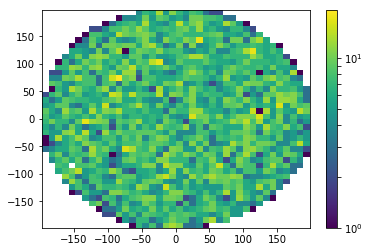

In [29]:
from matplotlib.colors import LogNorm
plt.hist2d(s2si.x, s2si.y, bins=40, norm=LogNorm())
plt.colorbar()
plt.show()

(array([  444.,   862.,  1017.,  1201.,  1203.,  1201.,  1087.,  1077.,
          863.,   459.]),
 array([ -1.97772551e+02,  -1.58220219e+02,  -1.18667886e+02,
         -7.91155540e+01,  -3.95632217e+01,  -1.08894295e-02,
          3.95414428e+01,   7.90937751e+01,   1.18646107e+02,
          1.58198440e+02,   1.97750772e+02]),
 <a list of 10 Patch objects>)

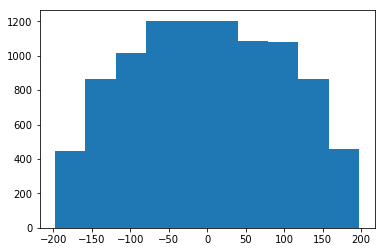

In [30]:
plt.hist(s2si.x)

(array([ 2047.,  3888.,  4545.,  5238.,  5344.,  5199.,  4775.,  4695.,
         4808.,  1937.]),
 array([-205., -164., -123.,  -82.,  -41.,    0.,   41.,   82.,  123.,
         164.,  205.]),
 <a list of 10 Patch objects>)

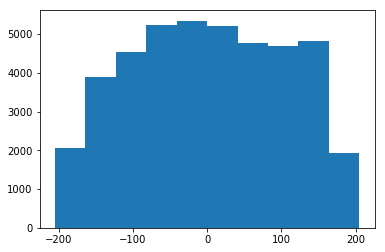

In [31]:
plt.hist(s2si.xsipms)

In [32]:
len(s2si.Qtot)

42476

In [33]:
len(s2si.xsipms)

42476

In [34]:
len(s2si.x)

9414

In [35]:
#x , y = np.average(s2si.xsipms, weights = s2si.Qtot), np.average(s2si.ysipms, weights = s2si.Qtot)

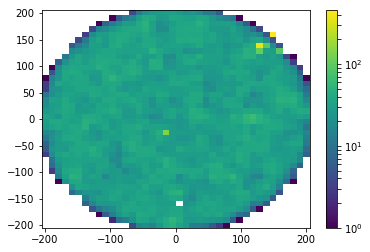

In [36]:
from matplotlib.colors import LogNorm
plt.hist2d(s2si.xsipms, s2si.ysipms, bins=40, norm=LogNorm())
plt.colorbar()
plt.show()

(array([  2.67320000e+04,   1.04590000e+04,   3.29400000e+03,
          1.16800000e+03,   4.65000000e+02,   1.87000000e+02,
          1.03000000e+02,   3.90000000e+01,   2.00000000e+01,
          9.00000000e+00]),
 array([  30.0000596 ,   83.20766368,  136.41526775,  189.62287183,
         242.8304759 ,  296.03807998,  349.24568405,  402.45328813,
         455.6608922 ,  508.86849627,  562.07610035]),
 <a list of 10 Patch objects>)

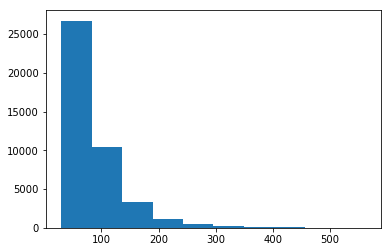

In [37]:
plt.hist(s2si.Qtot)

### Open the pytable file for MC truth extraction

In [38]:
table = tb.open_file(mydf_file,mode='r')

In [39]:
table.root.MC.MCTracks

/MC/MCTracks (Table(69606,), shuffle, zlib(4)) 'MCTracks'
  description := {
  "event_indx": Int16Col(shape=(), dflt=0, pos=0),
  "mctrk_indx": Int16Col(shape=(), dflt=0, pos=1),
  "particle_name": StringCol(itemsize=10, shape=(), dflt=b'', pos=2),
  "pdg_code": Int16Col(shape=(), dflt=0, pos=3),
  "initial_vertex": Float32Col(shape=(3,), dflt=0.0, pos=4),
  "final_vertex": Float32Col(shape=(3,), dflt=0.0, pos=5),
  "momentum": Float32Col(shape=(3,), dflt=0.0, pos=6),
  "energy": Float32Col(shape=(), dflt=0.0, pos=7),
  "nof_hits": Int16Col(shape=(), dflt=0, pos=8),
  "hit_indx": Int16Col(shape=(), dflt=0, pos=9),
  "hit_position": Float32Col(shape=(3,), dflt=0.0, pos=10),
  "hit_time": Float32Col(shape=(), dflt=0.0, pos=11),
  "hit_energy": Float32Col(shape=(), dflt=0.0, pos=12)}
  byteorder := 'little'
  chunkshape := (819,)

In [40]:
table_truth = table.root.MC.MCTracks
table = table_truth[:]

In [41]:
from collections import namedtuple
def xxx (mctruth_table, max_events=None):
    
    result = {}
    Tuple = namedtuple('sipms','momentum, position, energies, hit_energies')
    len_mc_truth_table = len(mctruth_table)

#    convert table to numpy.ndarray
    data       = mctruth_table[:]
    data_size  = len(data)

    event            =  data["event_indx"]
    particle         =  data["mctrk_indx"]
    particle_name    =  data["particle_name"]
    pdg_code         =  data["pdg_code"]
    initial_vertex   =  data["initial_vertex"]
    final_vertex     =  data["final_vertex"]
    momentum         =  data["momentum"]
    energy           =  data["energy"]
    nof_hits         =  data["nof_hits"]
    hit              =  data["hit_indx"]
    hit_position     =  data["hit_position"]
    hit_time         =  data["hit_time"]
    hit_energy       =  data["hit_energy"]

    event_boundary    = True
    particle_boundary = True
    hit_boundary      = True

    current_event    = -2
    current_particle = -1
    current_hit      = -1

    limit = np.iinfo(int).max if max_events is None or max_events < 0 else max_events
    
    for i in range(data_size):
        #print('+++++++++start loop = {}, event= {}, particle= {}, hit= {}'.format(i,event[i], particle[i], hit[i]))
        
        if(event_boundary):    # start new event
            current_event = event[i]
            #print('-----current event= {}'.format(current_event))
            if current_event >= limit: break
            event_data = {}

        if particle_boundary:  # Start new particle
            current_particle = particle[i]
            particle_data = {}

        if hit_boundary:  # Start new hit
            current_hit = hit[i]
            momentums, hit_positions, energies, hit_energies = [], [], [], []
           
           

       # Add position, momentum to current particle's data  
       
        momentums     .append(momentum    [i])
        hit_positions .append(hit_position[i])
        energies      .append(energy      [i])
        hit_energies  .append(hit_energy  [i])
      
        #print(momentum)

        event_boundary     = i+1 == data_size     or event     [i+1] != current_event
        particle_boundary  = event_boundary       or particle [i+1]  != current_particle
        hit_boundary       = particle_boundary    or hit      [i+1]  != current_hit
        
        if hit_boundary:  # End of hit: save it
            #print('end of hit')
#            particle_data[current_hit] = (momentums, hit_positions)
           # print(hit_position)
            particle_data[current_hit] = Tuple(np.array(momentums), 
                                               np.array(hit_positions), 
                                               np.array(energies), 
                                               np.array(hit_energies))
            
        if particle_boundary:  # End of particle: save it
            #print('end of particle')
            event_data[current_particle] = particle_data


        if event_boundary: # End of event: save it
            #print('end of event')
            result[current_event] = event_data
       
    
    return result




In [42]:
Truth_dict = xxx(table)

### Intersect Truth-dict with S2Si-reco-dict

In [43]:
keys_Truth_dict =  set(Truth_dict.keys())
keys_S2Si  =  set(S2Sidict.keys())
intsect = keys_Truth_dict & keys_S2Si

Truth_dict_map = filt_dict(Truth_dict,intsect)
S2Simap  = filt_dict(S2Sidict,intsect)

In [44]:
Truth_dict_map.keys() == S2Simap.keys()

True

### Truth features:



In [45]:


class T_S2SiProp:
    """
    properties
    """        
    
    def __init__(self, Tdict):
        self.Tdict    = Tdict
        self.length   = len(self.Tdict)
        self.prop()

    def dict(self):
            return self.Tdict


    def prop(self):
        self.xposition        = np.zeros(self.length, dtype=np.double) # 
        self.yposition        = np.zeros(self.length, dtype=np.double) # 
        self.energies         = np.zeros(self.length, dtype=np.double) # Particle's energy
        self.hit_energies     = np.zeros(self.length, dtype=np.double) # hit's energy
        self.edepo            = np.zeros(self.length, dtype=np.double) # Sum of energy_hits
        self.xtruth           = np.zeros(self.length, dtype=np.double) # x from barycenter
        self.ytruth           = np.zeros(self.length, dtype=np.double) # y from barycenter
        
        
        lxposition      = []
        lyposition      = []
        lenergies       = []
        lhit_energies   = []
        ledepo          = []
        lx              = []
        ly              = []
    
        energies = 0 
        for evtID, evt in self.Tdict.items(): 
            edepo = 0
            xsi   = []
            ysi   = []
            hitE  = []
            for particle, hits in evt.items(): 
                # fill energy of particles               
                for hitID, sipms in hits.items(): 
                    edepo = edepo + sipms.hit_energies               
                    lxposition    .append(sipms.position[0][0])
                    lyposition    .append(sipms.position[0][1])
                    lhit_energies .append(sipms.hit_energies)
                    ledepo        .append(edepo)
                    energies      = sipms.energies
                    xsi           .append(sipms.position[0][0])  
                    ysi           .append(sipms.position[0][1])
                    hitE          .append(sipms.hit_energies[0])
                    #print('xsi = {}'.format(xsi))
                    #print('ysi = {}'.format(ysi))
                    #print('hitE = {}'.format(hitE))
                    #print('sipms.hit_energies = {}'.format(sipms.hit_energies[0]))
                    #print('sipms.position[0][0] = {}'.format(sipms.position[0][0]))
                    
                
                # fill energy of particles 
                lenergies     .append(energies)  
           
            #fill weighted average per event
            xarray = np.array(xsi)
            yarray = np.array(ysi)
            Earray = np.array(hitE)
            lx  .append(np.average(xarray, weights = Earray))
            ly  .append(np.average(yarray, weights = Earray))
                
                
       # convert lists to numpy arrays
        self.xposition      = np.array(lxposition)  
        self.yposition      = np.array(lyposition)
        self.energies       = np.array(lenergies)
        self.hit_energies   = np.array(lhit_energies)
        self.edepo          = np.array(ledepo)
        self.xtruth         = np.array(lx)
        self.ytruth         = np.array(ly)



In [46]:
T = T_S2SiProp(Truth_dict_map)

In [47]:
T.xtruth

array([  1.43937210e+02,   1.41104758e-01,  -5.75221405e+01, ...,
         1.21402138e+02,   1.12295212e+02,  -3.84891582e+00], dtype=float32)

(array([  512.,   927.,  1097.,  1269.,  1266.,  1238.,  1139.,  1128.,
          910.,   496.]),
 array([ -1.97329407e+02,  -1.57873193e+02,  -1.18416980e+02,
         -7.89607666e+01,  -3.95045532e+01,  -4.83398438e-02,
          3.94078735e+01,   7.88640869e+01,   1.18320300e+02,
          1.57776514e+02,   1.97232727e+02]),
 <a list of 10 Patch objects>)

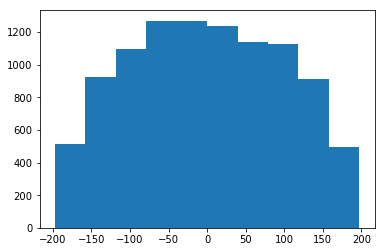

In [48]:
plt.hist(T.xtruth)

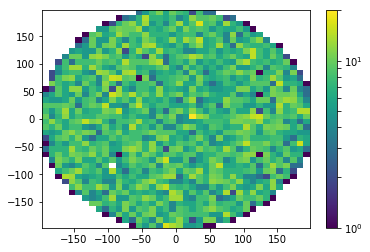

In [49]:
from matplotlib.colors import LogNorm
plt.hist2d(T.xtruth, T.ytruth, bins=40, norm=LogNorm())
plt.colorbar()
plt.show()

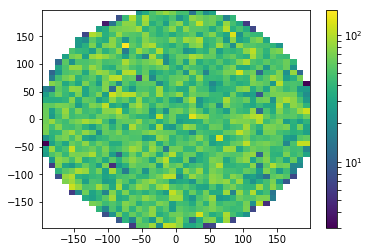

In [50]:
from matplotlib.colors import LogNorm
plt.hist2d(T.xposition, T.yposition, bins=40, norm=LogNorm())
plt.colorbar()
plt.show()

## Ongoing truth-reco comparison....

In [51]:
#plt.hist(T.xtruth-s2si.x)

In [52]:
len(Truth_dict_map)

9982